In [ ]:
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import tqdm
import sklearn
from sklearn import datasets
from sklearn import svm
from typing import Optional

In [ ]:
# MÔ HÌNH HỒI QUY TUYẾN TÍNH

In [ ]:
# LOAD DATA
X, y = datasets.load_boston(return_X_y=True)
X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
X.shape, y.shape

((506, 14), (506,))

In [ ]:
def run_time(f):
  def caller(*args, **kwargs):
    print(f"Phương pháp: {f.__name__}")
    t1 = time.time()
    out = f(*args, **kwargs)
    t2 = time.time()
    print(f"Thời gian chạy ước tính: {t2-t1}")
    return out
  return caller

In [ ]:
# IMPLEMENT NUMERICAL SOLUTION HERE
@run_time
def analytical_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

In [ ]:
# IMPLEMENT GRADIENT DESCENT HERE
# REQUIREMENTS: a function to calculate the gradient , a function to calculate the loss function, a function to excecute gradient descent

class LinearRegression:
  def predict(self, X: np.ndarray) -> np.ndarray:
      return X @ self.beta

  @staticmethod
  def cost_function(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
      y_ = X @ beta
      return np.mean((y_ - y)**2)

  @staticmethod
  def gradient(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
      y_ = X @ beta
      return 2 * np.mean((y_ - y).reshape(y.shape[0], 1) * X, axis=0)
        
  def fit(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float = 0.05):
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))

    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) >= tau:
        break
      
      # Update rule (Update parameter)
      beta = beta - gamma * self.gradient(X, y, beta)
      
      # Save progress
      loss.append(self.cost_function(X, y, beta))

    self.beta = beta
    self.loss = loss


  def fit_momentum(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float =0.05, alpha: float = 0.05, nesterov: bool=True):
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    delta_beta = np.zeros_like(beta)
    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) < tau:
          break
      # Update rule (Update parameter)
      if not nesterov:
          grad = self.gradient(X, y, beta)
      else:
          grad = self.gradient(X, y, beta + alpha * delta_beta)
      delta_beta = alpha * delta_beta - gamma * grad
      beta = beta + delta_beta
      
      # Save progress
      loss.append(self.cost_function(X, y, beta))
      
    self.beta = beta
    self.loss = loss

@run_time
def gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    model = LinearRegression()
    model.fit_momentum(X, y, gamma=0.000001, tau=0.00001, nesterov=True)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(np.arange(1, 1+len(model.loss)), model.loss)
    ax.set_title("Gradient descent")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    return model.beta

In [ ]:
# SOLUTION FROM SKLEARN
@run_time
def sklearn_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X[:, 1:], y)
    beta = np.empty(shape=(X.shape[1], ))
    beta[0], beta[1:] = model.intercept_, model.coef_
    return beta

In [ ]:
def mse(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> float:
    return float(np.mean((X @ beta - y)**2))

Phương pháp: analytical_solution
Thời gian chạy ước tính: 0.00795435905456543
Phương pháp: gradient_descent
Thời gian chạy ước tính: 43.32070827484131
Phương pháp: sklearn_solution
Thời gian chạy ước tính: 0.017885446548461914
[ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]
[ 0.41382391 -0.09020565  0.07666535 -0.00384337  0.24046584  0.21038689
  3.58688766  0.04218756 -0.56604515  0.16257374 -0.00923631  0.06071726
  0.01951824 -0.61882557]
[ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]
21.894831181729202
28.12035926611364
21.894831181729202


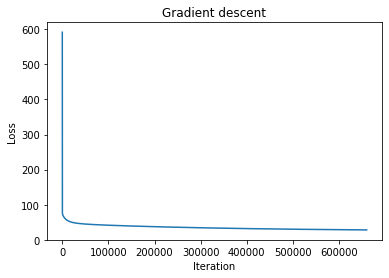

In [ ]:
# VISUALIZATION
beta1 = analytical_solution(X, y)
beta2 = gradient_descent(X, y)
beta3 = sklearn_solution(X, y)

print(beta1)
print(beta2)
print(beta3)

print(mse(X, y, beta1))
print(mse(X, y, beta2))
print(mse(X, y, beta3))

In [ ]:
# Nhận xét về sự giống và khác nhau của các thông số thời gian chạy, MSE và giá trị beta của 3 phương pháp trong mô hình hồi quy tuyến tính trên:
# Thời gian (analytical_solution) < thời gian (sklearn package) < thời gian (numerical solution)
# Do giá trị của beta như nhau nên MSE (analytical_solution) = MSE (sklearn package)
# Nguyên nhân: Tùy vào thời điểm bắt đầu của vector beta thì thời gian chạy và mse của phương pháp numerical cũng khác 2 phương pháp còn lại
# Sai số khác nhau kéo theo beta cũng sẽ khác nhau, do phương pháp chưa đi đến global minimal mà chỉ đang tìm đến các điểm gần nhau, điểm xuất phát cũng không
# cố định, ngoài ra cũng một phần do dữ liệu được sinh ngẫu nhiên

In [ ]:
# MÔ HÌNH HỒI QUY LOGISTIC

In [ ]:
X, y = datasets.load_breast_cancer(return_X_y=True)

# Normalized X
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
np.mean(X, axis=0), np.std(X, axis=0)

# Add one
X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
X.shape, y.shape


((569, 31), (569,))

In [ ]:
class LogisticRegression:
  def predict(self, X: np.ndarray) -> np.ndarray:
    return LogisticRegression.logistic_function(X @ self.beta)

  @staticmethod
  def logistic_function(t: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-t))
    
  @staticmethod
  def cost_function(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
      y_ = LogisticRegression.logistic_function(X @ beta)
      return - np.mean(y * np.log(y_) + (1-y) * np.log(1-y_))

  @staticmethod
  def gradient(X: np.ndarray, y: np.ndarray, beta: np.ndarray):
    y_ = X @ beta
    g =  np.mean((y_ - y).reshape(y.shape[0], 1) * X, axis=0)
    return g
    
  def fit(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float = 0.05):        
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    
    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) >= tau:
          break

      # Update parameter
      beta = beta - gamma * self.gradient(X, y, beta)
      
      # Save progress
      loss.append(self.cost_function(X, y, beta))

    self.beta = beta
    self.loss = loss

  def fit_momentum(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float =0.05, alpha: float = 0.05, nesterov: bool=True):
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    delta_beta = np.zeros_like(beta)
    self.cost_function(X, y, beta)

    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) < tau:
        break

      # Update rule (Update parameter)
      if not nesterov:
          grad = self.gradient(X, y, beta)
      else:
          grad = self.gradient(X, y, beta + alpha * delta_beta)
      delta_beta = alpha * delta_beta - gamma * grad
      beta = beta + delta_beta
      
      # Save progress
      loss.append(self.cost_function(X, y, beta))

    self.beta = beta
    self.loss = loss

@run_time
def gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    model = LogisticRegression()
    model.fit_momentum(X, y, gamma=0.000001, tau=0.0000001, nesterov=True)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(np.arange(1, 1+len(model.loss)), model.loss)
    ax.set_title("Gradient descent")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    return model.beta

In [ ]:
# SOLUTION FROM SKLEARN
@run_time
def sklearn_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    model.fit(X[:, 1:], y)
    beta = np.empty(shape=(X.shape[1], ))
    beta[0], beta[1:] = model.intercept_, model.coef_
    return beta

In [ ]:
def eval(X, y, beta):
    from sklearn.metrics import classification_report
    y_ = LogisticRegression.logistic_function(X @ beta) > 0.5
    print(classification_report(y, y_))

Phương pháp: gradient_descent
Thời gian chạy ước tính: 65.28488421440125
Phương pháp: sklearn_solution
Thời gian chạy ước tính: 0.013290166854858398
[ 0.15503179 -0.04678505 -0.05021178 -0.02351217 -0.01865069 -0.0268687
 -0.03691786 -0.0429292  -0.07205042  0.03228249  0.02216506 -0.00662461
 -0.01385126 -0.02623917 -0.04352479 -0.03542327  0.08388218 -0.00674465
  0.02315594  0.01277269 -0.0165162  -0.04857655 -0.05014556 -0.00323106
  0.03954643 -0.00602589 -0.02763289 -0.077733   -0.01708457  0.0010382
 -0.02495318]
[ 0.21456573 -0.36317072 -0.38770299 -0.35111444 -0.43555896 -0.16176493
  0.56259548 -0.85989759 -0.96222175  0.07616775  0.32218585 -1.29103479
  0.26892526 -0.65988685 -1.01250087 -0.27717046  0.7362824   0.11052647
 -0.3335099   0.29590225  0.68091528 -1.02936114 -1.31459312 -0.82331706
 -1.01059356 -0.67073135  0.04465888 -0.87330064 -0.91195815 -0.88789694
 -0.47983137]
              precision    recall  f1-score   support

           0       0.99      0.83      0

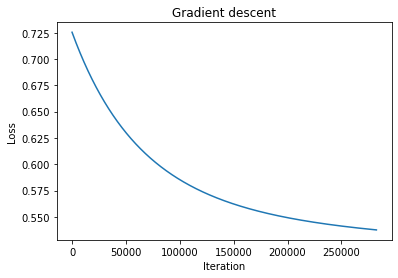

In [ ]:
# VISUALIZATION
beta1 = gradient_descent(X, y)
beta2 = sklearn_solution(X, y)

print(beta1)
print(beta2)

eval(X, y, beta1)
eval(X, y, beta2)

In [ ]:
# SỬ DỤNG SUPPORT VECTOR MACHINE

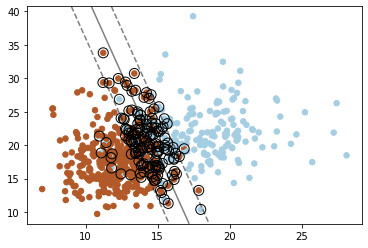

In [ ]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X = X[:,:2]

# Fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# Plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()